In [23]:
#@title imports 
import os
import pickle
from typing import Set
# from jedi import settings
import numpy as np 
import matplotlib.pyplot as plt
from numpy.lib.function_base import append 
import scipy.io as spio
from scipy.io import loadmat, savemat
from sklearn import datasets, linear_model
import matplotlib.pyplot as plt
from scipy.sparse import data 
import pandas as pd 
import matplotlib as mpl 
import seaborn as sns 
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import SparsePCA
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
from matplotlib.ticker import NullFormatter
from sklearn import manifold, datasets
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
# import umap.plot as uplot
from sknetwork.clustering import Louvain,get_modularity
from sknetwork.data import karate_club
import sys 

sys.path.append('C:/Users/Nishant Joshi/Downloads/Old_code/repo/single_cell_analysis/scripts')
from utils import *
from sknetwork.clustering import Louvain,get_modularity
from sknetwork.data import karate_club
import umap
import hdbscan

import sklearn.cluster as cluster
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score
pd.options.mode.use_inf_as_na = True

In [1]:
def return_confusion_matrix(df1,df2,label1_name,label2_name):
    df = pd.DataFrame(columns=['label1','label2'])
    df['exp_name1'] = df1.exp_name
    df['exp_name2'] = df2.exp_name
    df['label1'] = np.array(df1[label1_name])
    df['label2'] = np.array(df2[label2_name])

    mat = np.zeros((len(set(df1[label1_name])),len(set(df2[label2_name]))))

    for i in np.unique(df.label1):
        data_ = np.unique(df[df.label1==i]['label2'],return_counts=True)
        mat[i,data_[0]] =(data_[1]/sum(data_[1]))*100 

    sns.heatmap(mat,cmap='BrBG_r',annot=True) 

    plt.show()


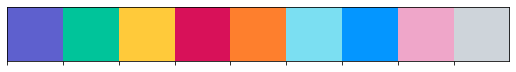

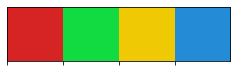

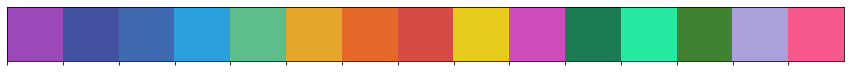

In [4]:
pal = ["#00202e","#003f5c","#2c4875","#8a508f","#bc5090","#ff6361","#ff8531","#ffa600","#ffd380"]
CUSTOM_PAL_SORT_3 = ['#5e60ce','#00c49a','#ffca3a','#D81159','#fe7f2d','#7bdff2','#0496ff','#efa6c9','#ced4da']
GMM_PAL = ['#d62424','#12db41','#f0c905','#248cd6']

# In RGB form
coherence_colors = [[0.609, 0.283, 0.724],
                    [0.259,	0.314, 0.635],
                    [0.251,	0.412, 0.698],
                    [0.176,	0.631, 0.859],
                    [0.369,	0.749, 0.549],
                    [0.898,	0.654, 0.169],
                    [0.898,	0.41 , 0.165],
                    [0.834,	0.3 , 0.265],
                    [0.912,	0.8 , 0.112],
                    [0.812,	0.3 , 0.734],
                    [0.109, 0.483, 0.324],
                    [0.159,	0.914, 0.635],
                    [0.251,	0.512, 0.198],
                    [0.676,	0.631, 0.859],
                    [0.969,	0.349, 0.549],]
sns.palplot(CUSTOM_PAL_SORT_3)
sns.palplot(GMM_PAL)
sns.palplot(coherence_colors)

In [5]:
discarded_exps = ['xuan_151118_E1',
'xuan_15319_E1' ,
'xuan_20919_E2',
'xuan_27919_E1',
'xuan_27919_E2',
'xuan_27919_E3',
'NC_20717_E5' ,
'NC_25717_E2',
'payam_31019_E5',
'payam_101019_E5',
'NC_24717_E1']

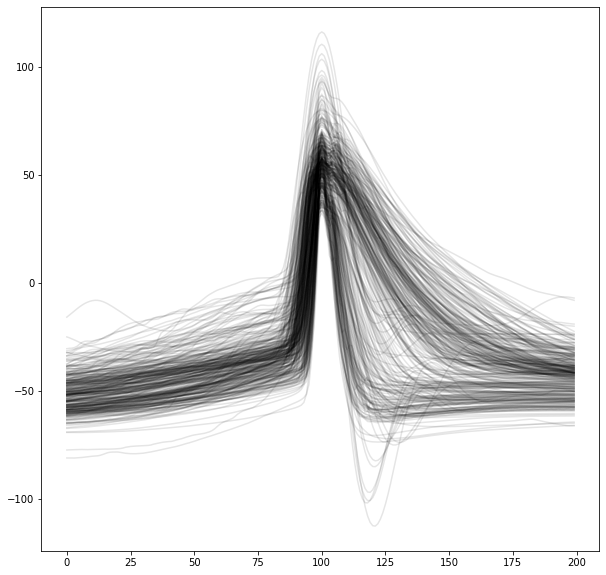

In [6]:
# %matplotlib widget

ephys = pd.read_pickle("D:/FN_analysed_feat_set/Ephys_collection_all_exps_all_conds_spikes_calculated.pkl")
ephys = ephys[~ephys.exp_name.isin(discarded_exps)]


data_ephys_FN_acsf = ephys[ephys.cond.isin(['acsf','acsf_bic'])][ephys.columns[1:]]
data_ephys_FN_acsf = data_ephys_FN_acsf[data_ephys_FN_acsf.trialnr==0]


data_wave_FN_acsf = ephys[ephys.cond.isin(['acsf','acsf_bic'])][['waveform','tau', 'exp_name', 'cond', 'trialnr']]
data_wave_FN_acsf=data_wave_FN_acsf[data_wave_FN_acsf.trialnr==0]
data_wave_FN_acsf.drop_duplicates('exp_name')

# exps_with_double_trials = np.array(data_wave_FN_acsf.exp_name)[list(np.where(np.unique(data_wave_FN_acsf.exp_name,return_counts=True)[1]>1)[0])]
# data_wave_FN_acsf = data_wave_FN_acsf[data_wave_FN_acsf.trialnr==0]

fig,ax = plt.subplots(figsize=[10,10])
# plt.ion
plt.plot(np.vstack(data_wave_FN_acsf['waveform']).T,c='k',alpha=0.1)
plt.show()


In [7]:
def plot_UMAP_clusters_single(data_inh, neighbours, distance, res_louvain, random_state,annotate=False,norm=True, c_list=None ,title=None,save=False):
    """plots UMAP for excitatory and inhibitory cells 

    Args:
        data_inh (ndarray): cell X feature matrix for inhibitory cells
        data_exc (ndarray): cell X feature matrix for excitatory cells
        c_exc (array): _description_
        c_inh (array): _description_
        neighbours (int): number of neares neighbours
        distance (float): minimum distance between points
    """
    data_umap_scaler = StandardScaler()
    data_umap = data_umap_scaler.fit_transform(data_inh)
    if norm:
        data_umap = normalize(data_umap)
    
    neighbours = neighbours
    dist = distance
    reducer = umap.UMAP(n_neighbors=neighbours,min_dist=dist,random_state=random_state)
    mapper = reducer.fit(data_umap)
    
    fig = plt.figure(figsize=[8,8])
    ax12d = fig.add_subplot(1,1,1)
    
    louvain = Louvain(resolution=res_louvain,random_state=random_state)
    adjacency = mapper.graph_
    labels_exc = louvain.fit_predict(adjacency)

    print(len(set(labels_exc)))
    clusterable_embedding2d = umap.UMAP(n_neighbors=neighbours,min_dist=dist,
        n_components=2,random_state=random_state,).fit_transform(data_umap)



    df_2d_exc = {'UMAP1':clusterable_embedding2d[:, 0],
             'UMAP2':clusterable_embedding2d[:, 1],
             'class':labels_exc}

    ax12d.set_xticks([])
    ax12d.set_yticks([])

    sns.scatterplot(data=df_2d_exc,x='UMAP1',y='UMAP2',hue='class',palette=c_list[:len(set(labels_exc))],ax=ax12d)
    if annotate:
        for i in range(len(clusterable_embedding2d)):

            plt.annotate(str(i),(clusterable_embedding2d[i,0]+0.05,clusterable_embedding2d[i,1]+0.05))

        # sns.scatterplot(data=df_2d_exc,x='UMAP1',y='UMAP2',hue='class',ax=ax12d)

        # ax12d.set_title('UMAP clusters for excitatory neurons 2D')
        ax12d.legend()
    if save:
        plt.savefig('C:/Users/Nishant Joshi/Documents/DNM/exc_umap_cluster.png',dpi=200)
    if title!=None:
        plt.title(title)
    plt.show()

    return labels_exc,mapper,reducer

In [8]:
waves = normalize(np.vstack(data_wave_FN_acsf['waveform']))

# find_optimum_res(waves)

c:\Users\Nishant Joshi\anaconda3\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


8


c:\Users\Nishant Joshi\anaconda3\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


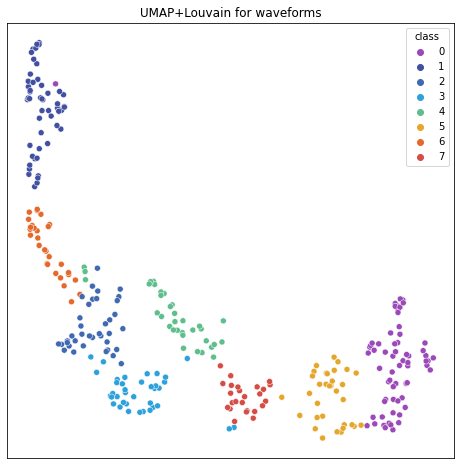

In [9]:
labels_wave,mapper,reducer = plot_UMAP_clusters_single(waves,
                          20,
                          0.1,
                          random_state =42,
                          res_louvain = 1.,
                          c_list =coherence_colors,
                          title='UMAP+Louvain for waveforms')
data_wave_FN_acsf['labels_wave'] = labels_wave

In [10]:
data_ephys_FN_acsf['labels_wave'] = labels_wave

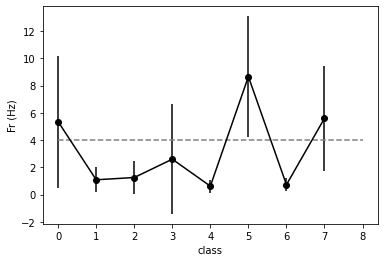

In [11]:
frs = []
frs_std = []
for i in set(data_ephys_FN_acsf['labels_wave']):
    frs.append(np.mean(data_ephys_FN_acsf[data_ephys_FN_acsf.labels_wave==i]['fr']))
    frs_std.append(np.std(data_ephys_FN_acsf[data_ephys_FN_acsf.labels_wave==i]['fr']))


plt.errorbar(list(set(data_ephys_FN_acsf['labels_wave'])),frs,yerr=frs_std,marker='o',c='black')
plt.hlines(4,0,8,linestyles='dashed',color='grey')
plt.ylabel('Fr (Hz)')
plt.xlabel('class')
plt.show()

In [32]:

data_ephys_FN_acsf['labels_wave'] = labels_wave
ephys_exc = data_ephys_FN_acsf[data_ephys_FN_acsf.labels_wave.isin([1,2,3,4,6])]
ephys_inh = data_ephys_FN_acsf[data_ephys_FN_acsf.labels_wave.isin([0,5,7])]
cols = ephys_exc.columns
ephys_exc_for_cluster = ephys_exc[cols[:-5]].to_numpy()
ephys_inh_for_cluster = ephys_inh[cols[:-5]].to_numpy()

In [33]:
clusterable_embedding_exc = umap.UMAP(
    n_neighbors=20,
    min_dist=0.1,
    n_components=2,
    random_state=42,
).fit_transform(ephys_exc_for_cluster)

clusterable_embedding_inh = umap.UMAP(
    n_neighbors=20,
    min_dist=0.1,
    n_components=2,
    random_state=42,
).fit_transform(ephys_inh_for_cluster)

c:\Users\Nishant Joshi\anaconda3\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
c:\Users\Nishant Joshi\anaconda3\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [34]:
standard_embedding_exc = umap.UMAP(random_state=42).fit_transform(ephys_exc_for_cluster)
standard_embedding_inh = umap.UMAP(random_state=42).fit_transform(ephys_inh_for_cluster)


c:\Users\Nishant Joshi\anaconda3\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
c:\Users\Nishant Joshi\anaconda3\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [35]:
labels_exc = hdbscan.HDBSCAN(
    min_samples=10,
    min_cluster_size=10,
).fit_predict(clusterable_embedding_exc)

labels_inh = hdbscan.HDBSCAN(
    min_samples=10,
    min_cluster_size=10,
).fit_predict(clusterable_embedding_inh)

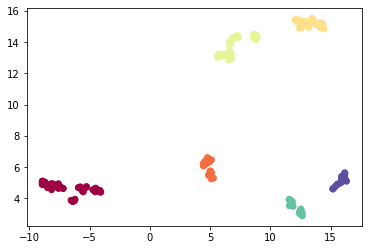

In [40]:
clustered = (labels_exc >= 0)
plt.scatter(clusterable_embedding_exc[~clustered, 0],
            clusterable_embedding_exc[~clustered, 1],
            color=(0.5, 0.5, 0.5),
            # s=1,
            alpha=0.5)
plt.scatter(clusterable_embedding_exc[clustered, 0],
            clusterable_embedding_exc[clustered, 1],
            c=labels_exc[clustered],
            # s=1,
            cmap='Spectral')

In [38]:
print(set(labels_exc))
print(set(labels_exc))


{0, 1, 2, 3, 4, 5}
{0, 1, 2, 3, 4, 5}


In [41]:
labels

array([3, 3, 3, 0, 0, 3, 3, 4, 1, 3, 3, 0, 1, 0, 2, 3, 4, 4, 0, 0, 0, 0,
       2, 1, 5, 0, 3, 0, 0, 4, 5, 1, 1, 0, 5, 2, 1, 2, 2, 0, 1, 3, 2, 5,
       0, 2, 3, 2, 2, 2, 1, 2, 1, 1, 0, 0, 0, 0, 0, 0, 5, 4, 2, 0, 1, 4,
       2, 0, 0, 0, 4, 0, 5, 2, 4, 0, 0, 3, 2, 3, 3, 5, 0, 0, 0, 3, 2, 3,
       0, 1, 3, 4, 1, 0, 4, 3, 4, 2, 0, 0, 3, 0, 3, 3, 0, 0, 2, 5, 3, 1,
       5, 3, 1, 3, 2, 0, 2, 4, 0, 4, 5, 0, 0, 4, 3, 1, 0, 4, 3, 5, 5, 0,
       0, 3, 5, 1, 4, 3, 5, 0, 2, 5, 0, 3, 5, 3, 5, 3, 4, 1, 5, 4, 2, 3,
       4, 2, 2, 3, 2, 3, 2, 0, 2, 3, 3, 5, 2, 2, 3, 3, 1, 1, 0, 5, 4, 3,
       0, 3, 0, 4, 2, 2, 1, 0, 1, 1, 2, 0, 3, 3], dtype=int64)

In [ ]:
adjusted_rand_score(mnist.target, labels), adjusted_mutual_info_score(mnist.target, labels)
